In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import tensorflow as tf

tflite_model_name = 'cnn_sine_model'  # Will be given .tflite suffix
c_model_name = 'cnn_sine_model'       # Will be given .h suffix

In [2]:
# Generate sine wave data
x = np.linspace(0, 2*np.pi, 1000)
y = np.sin(x)

# Add some noise to the data
y += np.random.normal(0, 0.1, y.shape)

# Create features using sine function with different phases
x_features = np.array([np.sin(x + i*np.pi/4) for i in range(5)]).T

# Reshape the data for LSTM input (add extra dimension for time steps)
x_features = x_features.reshape(-1, 5, 1)  # (batch_size, timesteps, input_dim)

print(x_features.shape)
print(x_features[0,:])
print(x_features[1,:])

(1000, 5, 1)
[[0.00000000e+00]
 [7.07106781e-01]
 [1.00000000e+00]
 [7.07106781e-01]
 [1.22464680e-16]]
[[ 0.00628943]
 [ 0.7115401 ]
 [ 0.99998022]
 [ 0.70264549]
 [-0.00628943]]


In [9]:
# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with single neuron for regression
])
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(x_features, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 2s 14ms/step - loss: 0.4516 - val_loss: 0.2973
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 0.1901 - val_loss: 0.1333
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0477 - val_loss: 0.0152
Epoch 4/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0143
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 8/20
25/25 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 9/20
25/25 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 10/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 11/20
25/25 

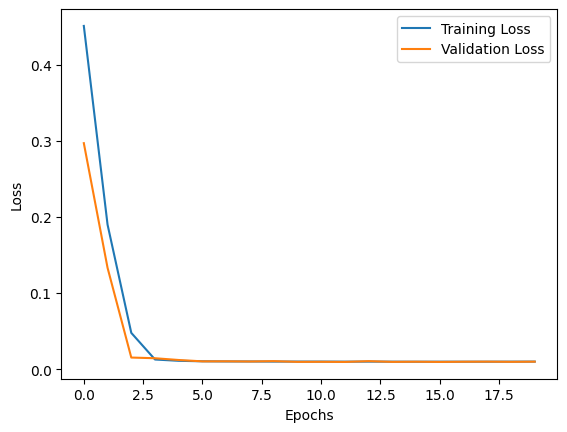

4/4 [==============================] - 0s 5ms/step


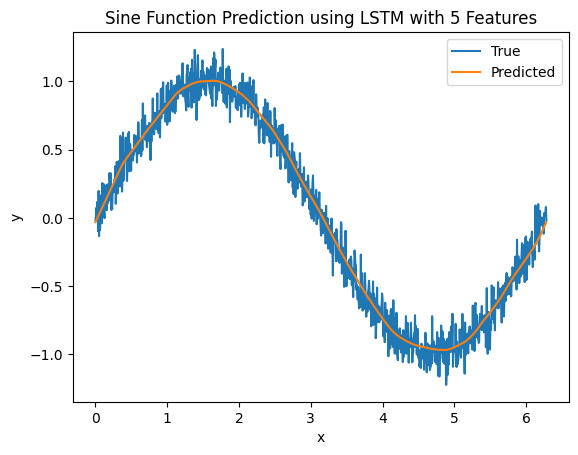

In [10]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict with the model
x_test = np.linspace(0, 2*np.pi, 100)
x_test_features = np.array([np.sin(x_test + i*np.pi/4) for i in range(5)]).T
x_test_features = x_test_features.reshape(-1, 5, 1)  # Reshape for prediction
y_pred = model.predict(x_test_features)

# Plot the predictions
plt.plot(x, y, label='True')
plt.plot(x_test, y_pred, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Sine Function Prediction using LSTM with 5 Features')
plt.show()


In [7]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\surface\AppData\Local\Temp\tmp3ihafrtb\assets


INFO:tensorflow:Assets written to: C:\Users\surface\AppData\Local\Temp\tmp3ihafrtb\assets


6276

In [8]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))